<center><h1>Fernandes_Alrik_HW6</h1></center>

Name: Alrik Fernandes
<br>
Github Username: AlrikF 
<br>
USC ID: 4036859519


### I have used one late day token for the submission of this assignment

## 1. Tree-Based Methods

Import packages

In [26]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt 
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, f1_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV ,KFold
from imblearn.over_sampling import SMOTE
from sklearn import svm

### (a) Download the APS Failure data

In [84]:
aps_train_df = pd.read_csv("../data/aps_failure_training_set.csv", skiprows=20).replace("na",np.nan)
aps_test_df = pd.read_csv("../data/aps_failure_test_set.csv", skiprows=20).replace("na",np.nan)
X_train,y_train= aps_train_df.iloc[:,1:],aps_train_df.iloc[:,0].replace("pos",1).replace("neg",0)
X_test,y_test= aps_test_df.iloc[:,1:],aps_test_df.iloc[:,0].replace("pos",1).replace("neg",0)

In [85]:
X_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698,NaN,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,33058,NaN,0,NaN,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,41040,NaN,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,12,0,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,60874,NaN,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [86]:
X_test.head()


,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60,0,20,12,0,0,0,0,0,2682,...,1098,138,412,654,78,88,0,0,0,0
1,82,0,68,40,0,0,0,0,0,0,...,1068,276,1620,116,86,462,0,0,0,0
2,66002,2,212,112,0,0,0,0,0,199486,...,495076,380368,440134,269556,1315022,153680,516,0,0,0
3,59816,NaN,1010,936,0,0,0,0,0,0,...,540820,243270,483302,485332,431376,210074,281662,3232,0,0
4,1814,NaN,156,140,0,0,0,0,0,0,...,7646,4144,18466,49782,3176,482,76,0,0,0


### (b) Data Preparation

#### (i) Research what types of techniques are usually used

1)Skip performing imputation:
Some algorithms can factor in the missing values and learn the best imputation values for the missing data based on the training loss reduction (ie. XGBoost). Some others have the option to just ignore them (ie. LightGBM — use_missing=false) in this case we can chose to ignore imputation as well

2)Imputation Using (Mean/Median) Values (Only for numerical data) 

3)Imputation Using (Most Frequent) or (Zero/Constant) Values (Can be used for categorical variables as well

4)Imputation Using k-NN

5)Imputation Using Multivariate Imputation by Chained Equation (MICE)

6)Imputation Using Deep Learning

7)Imputation Using Deep Learning

8)Stochastic regression imputation

For univariate data usual mean, median or mode is used  

In [87]:
si = SimpleImputer(strategy='mean', missing_values=np.nan)
X_train_imp = pd.DataFrame(si.fit_transform(X_train), columns = X_train.columns)
X_test_imp = pd.DataFrame(si.fit_transform(X_test), columns = X_test.columns)

#### (ii) Calculate the coefficient of variation

In [88]:
cv_vals = pd.DataFrame([X_train_imp.apply(lambda x:np.std(x)/np.mean(x))], columns = X_train.columns)
cv_vals

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,2.450917,2.328381,2.169748,183.846088,23.190743,18.658766,91.877799,34.85466,17.368999,8.549978,...,2.579298,2.558977,2.60638,2.829698,3.192101,4.962441,3.221983,5.626932,47.12456,40.552912


#### (iii) Plot a correlation matrix

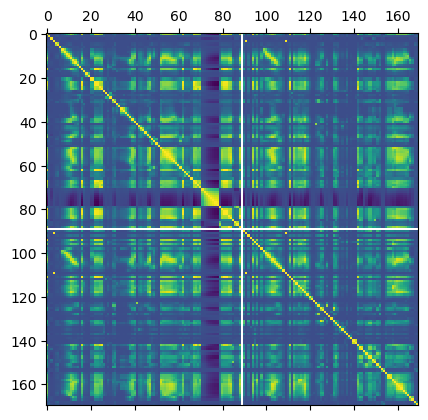

In [89]:

corr_mat = X_train_imp.corr()
plt.matshow(corr_mat)
plt.show()

#### (iv) Make scatter plots and box plots

In [90]:
thresh = sorted(X_train_imp.apply(lambda x:np.std(x)/np.mean(x)))[-int(math.sqrt(len(X_train_imp.columns)))]

a=[]
for i,val in enumerate(cv_vals):
    if cv_vals.loc[0,val]>=thresh:
        a.append(X_train_imp.columns[i])
cv_vals = pd.DataFrame([X_train_imp.apply(lambda x:np.std(x)/np.mean(x))],columns=X_train_imp.columns)

highest_cvs = X_train_imp.loc[:,a]
highest_cvs["class"]=y_train

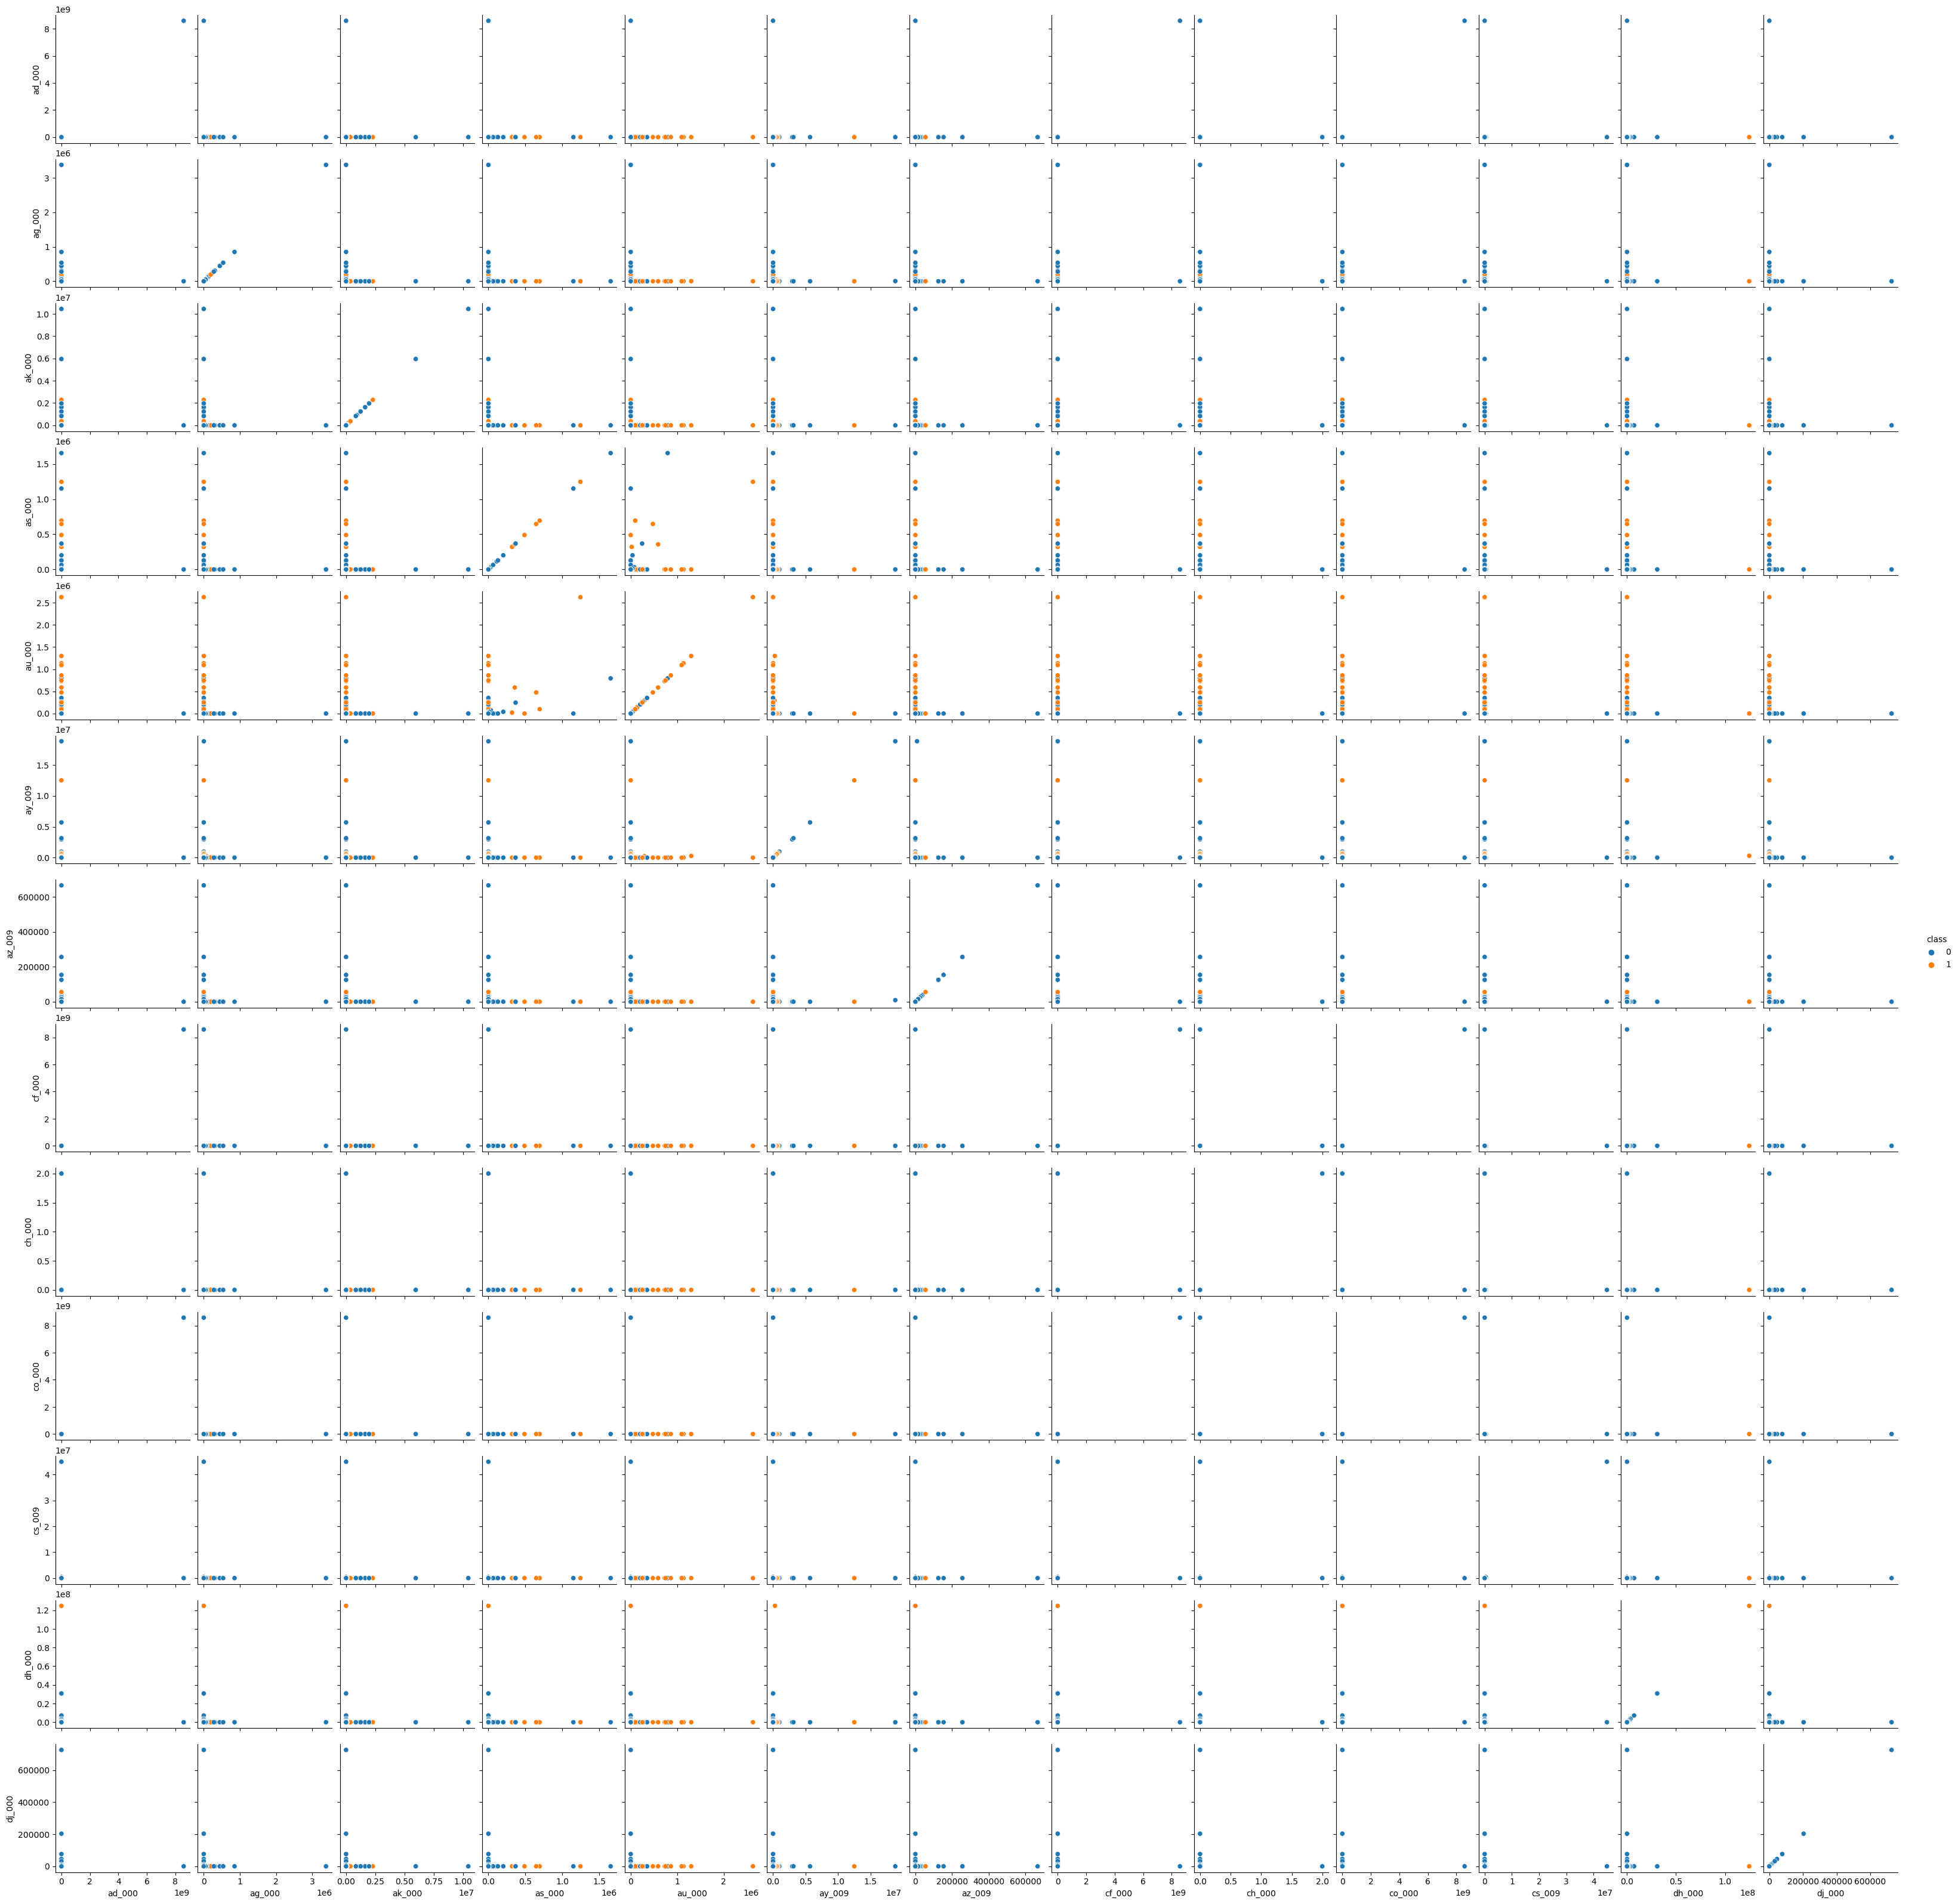

In [91]:
sns.pairplot(highest_cvs,diag_kind=None,hue="class")

[]

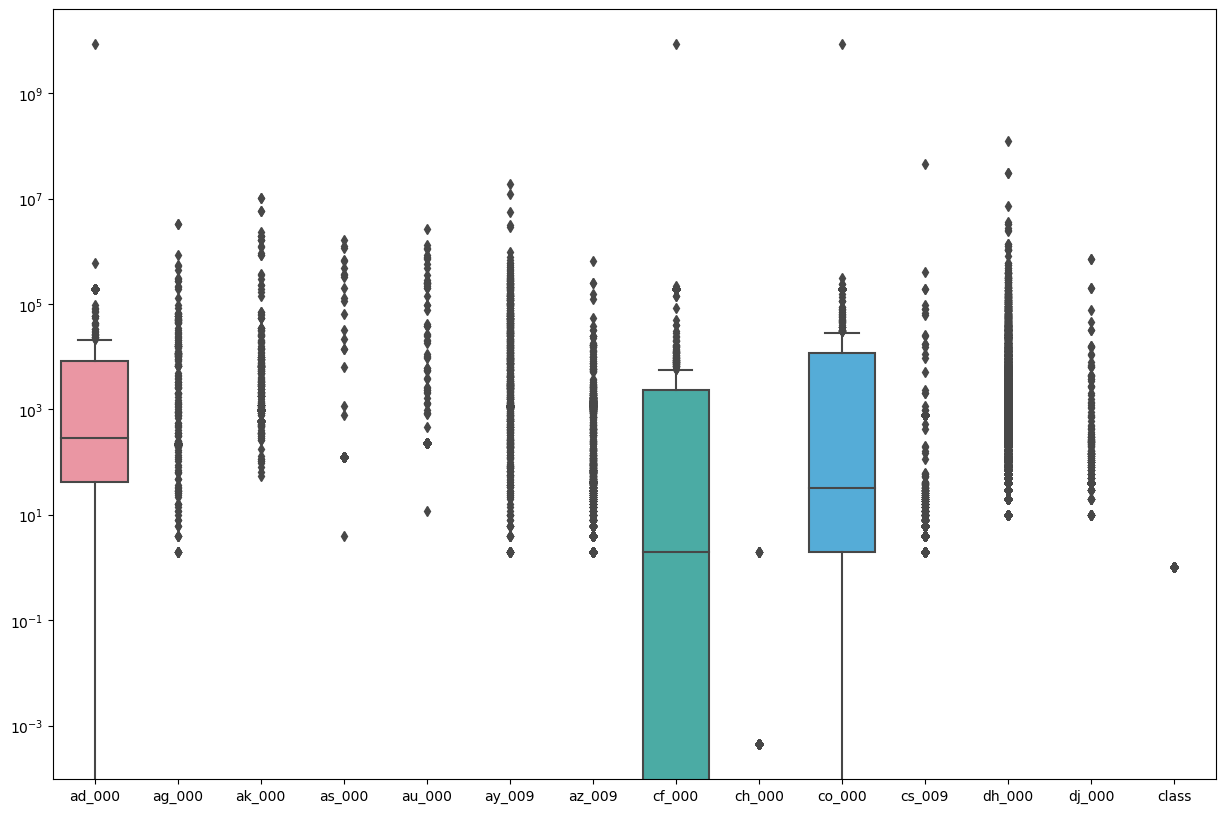

In [92]:
fig, axes = plt.subplots(figsize=(15, 10))
box = sns.boxplot(highest_cvs)
box.set(yscale="log")
plt.plot()

From the scatter plots it is not apparent if the datasets are imbalanced as the plots seem very scattered

#### (v) Is this data set imbalanced?

In [93]:

print(y_train.value_counts())
print(y_test.value_counts())


0    59000
1     1000
Name: class, dtype: int64
0    15625
1      375
Name: class, dtype: int64


### Yes the dataset is  imbalanced 

### (c) Train a random forest

In [94]:
rforest = RandomForestClassifier( random_state=1,oob_score=True)
rforest.fit(X_train_imp,y_train)
rf_pred_train= rforest.predict(X_train_imp)
rf_pred_test= rforest.predict(X_test_imp)
 




Accuracy for training set is 1.0

AUC for train is 1.0


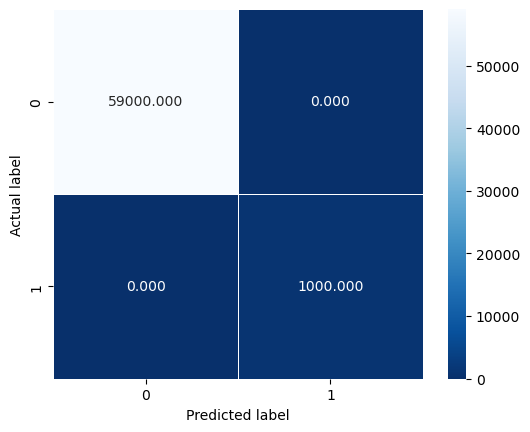

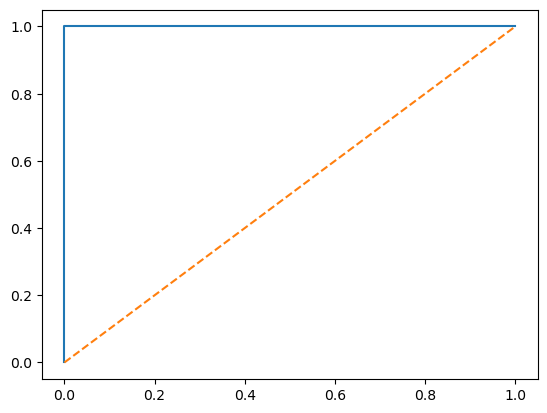

In [95]:
#Train Confusion Matrix
sns.heatmap(confusion_matrix(y_train,rf_pred_train), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"\nAccuracy for training set is {accuracy_score(y_train, rf_pred_train)}")
print(f"\nAUC for train is {roc_auc_score(y_train, rf_pred_train)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_train, rf_pred_train)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()


Accuracy for test set is 0.9921875
AUC for test is 0.855456


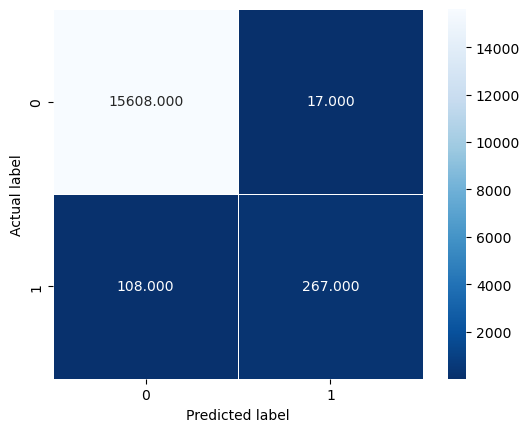

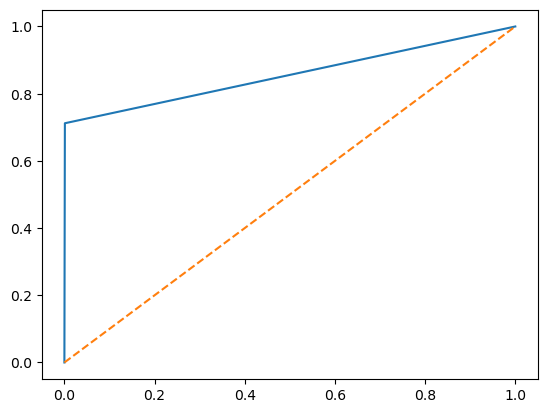

In [96]:
#Test Confusion Matrix 
sns.heatmap(confusion_matrix(y_test,rf_pred_test), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label')

print(f"\nAccuracy for test set is {accuracy_score(y_test, rf_pred_test)}")
print(f"AUC for test is {roc_auc_score(y_test, rf_pred_test)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_test, rf_pred_test)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()

In [97]:
print(f"Out of Bag error on train set  is {1- rforest.oob_score_}")
print(f"Test  set  error is {1-accuracy_score(y_test, rf_pred_test)}")


Out of Bag error on train set  is 0.005850000000000022
Test  set  error is 0.0078125


### (d) Research class imbalance in random forest

1)Random Forest can handle imbalanced classification by changing the weight that each class has when calculating the impurity score of a chosen split point.Setting the class_weight argument on the RandomForestClassifier class to 'balanced'  makes use of the inverse weighting from the training dataset focusing on the minority class.

2)Class Imbalance can additionally hadled by changing the class distribution. The BalancedRandomForestClassifier class from the imbalanced-learn library implements this and performs random undersampling of the majority class in reach bootstrap sample. This is generally referred to as Balanced Random Forest.

3)The Easy Ensemble involves creating balanced samples of the training dataset by selecting all examples from the minority class and a subset from the majority class. Rather than using pruned decision trees, boosted decision trees are used on each subset, specifically the AdaBoost algorithm. AdaBoost works by first fitting a decision tree on the dataset, then determining the errors made by the tree and weighing the examples in the dataset by those errors so that more attention is paid to the misclassified examples and less to the correctly classified examples. A subsequent tree is then fit on the weighted dataset intended to correct the errors. The process is then repeated for a given number of decision trees.

In [98]:
rforest_bal = RandomForestClassifier( random_state=1,class_weight='balanced', oob_score=True)
rforest_bal.fit(X_train_imp,y_train)
rf_pred_train= rforest_bal.predict(X_train_imp)
rf_pred_test= rforest_bal.predict(X_test_imp)
 


Accuracy for training set is 1.0

AUC for train is 1.0


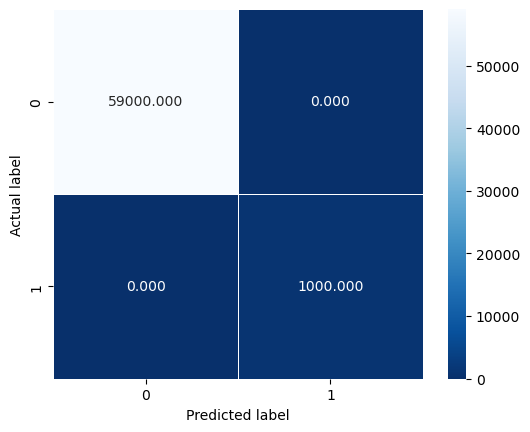

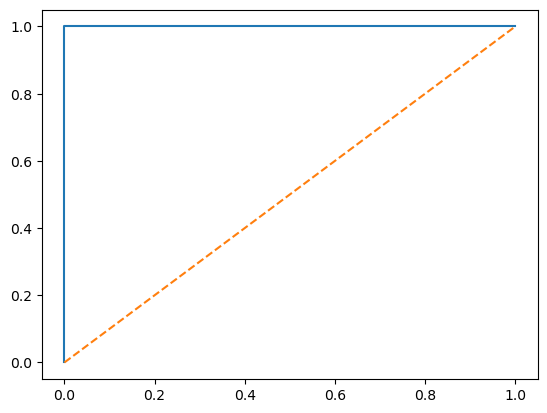

In [99]:
#Train Confusion Matrix
sns.heatmap(confusion_matrix(y_train,rf_pred_train), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"\nAccuracy for training set is {accuracy_score(y_train, rf_pred_train)}")
print(f"\nAUC for train is {roc_auc_score(y_train, rf_pred_train)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_train, rf_pred_train)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()


Accuracy for test set is 0.9889375
AUC for test is 0.7770133333333333


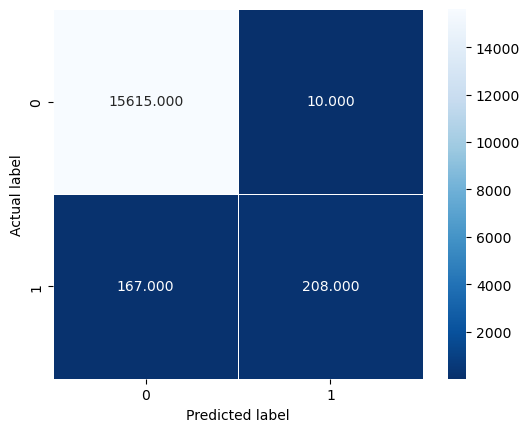

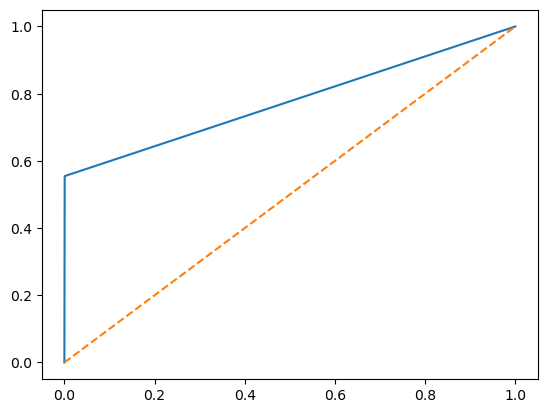

In [100]:
#Test Confusion Matrix 
sns.heatmap(confusion_matrix(y_test,rf_pred_test), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label')

print(f"\nAccuracy for test set is {accuracy_score(y_test, rf_pred_test)}")
print(f"AUC for test is {roc_auc_score(y_test, rf_pred_test)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_test, rf_pred_test)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()

In [101]:
print(f"Out of Bag error on train set  is {1- rforest.oob_score_}")
print(f"Test  set  error is {1-accuracy_score(y_test, rf_pred_test)}")

Out of Bag error on train set  is 0.005850000000000022
Test  set  error is 0.011062499999999975


It performs worse when the class weights are inverted according to the occurence 

### (e) XGBoost and Model Trees

In [38]:
xgb_model = XGBClassifier(objective='binary:logistic',max_depth = 7)
alphas = {'reg_alpha': [10**i for i in range(-4,4)]}
cv = KFold(n_splits=5,shuffle=True,random_state=1)
gscv = GridSearchCV(xgb_model, alphas,cv=cv,  scoring="accuracy")
gscv.fit(X_train_imp, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'reg_alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,
                                       1, 10, 100, 1000, 10000, 100000]},
             scoring='accuracy')

In [45]:
print(f"Optimal alpha found is {gscv.best_params_}")
xgb_model = XGBClassifier(objective='binary:logistic',reg_alpha=gscv.best_params_['reg_alpha'],max_depth = 7)
xgb_model.fit(X_train_imp, y_train)
xgb_pred_train= xgb_model.predict(X_train_imp)
xgb_pred_test= xgb_model.predict(X_test_imp)
 

Optimal alpha found is {'reg_alpha': 0.1}



Accuracy for training set is 0.9999833333333333

AUC for train is 0.9995


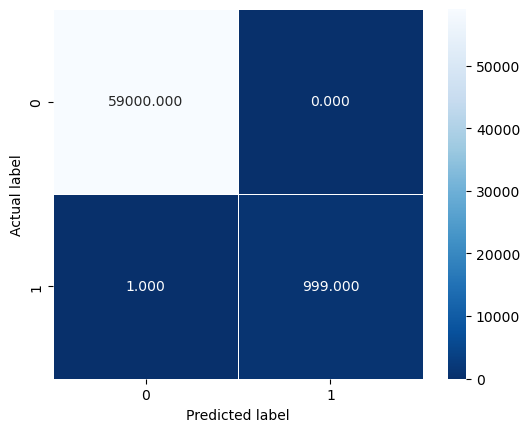

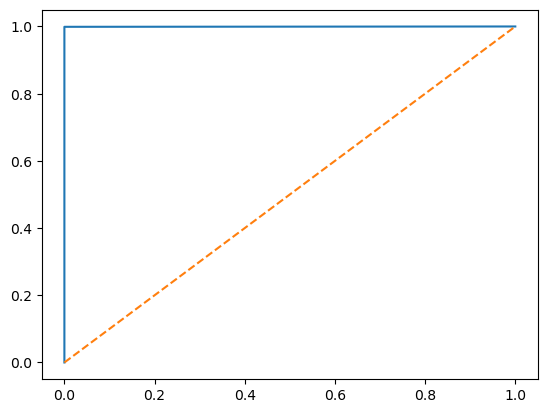

In [46]:
#Train Confusion Matrix
sns.heatmap(confusion_matrix(y_train,xgb_pred_train), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"\nAccuracy for training set is {accuracy_score(y_train, xgb_pred_train)}")
print(f"\nAUC for train is {roc_auc_score(y_train, xgb_pred_train)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_train, xgb_pred_train)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()


Accuracy for test set is 0.99425
AUC for test is 0.8968533333333333


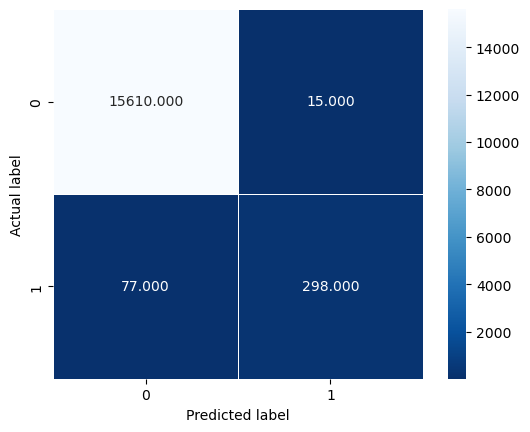

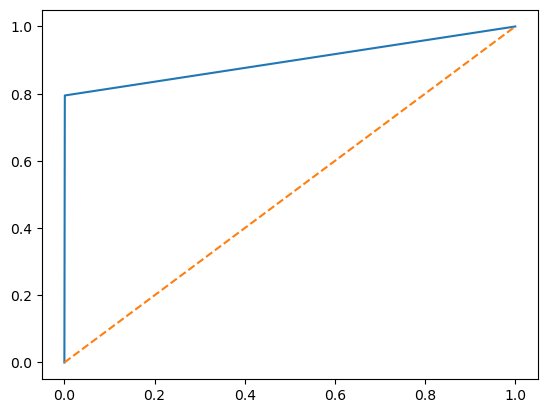

In [48]:
#Test Confusion Matrix 
sns.heatmap(confusion_matrix(y_test,xgb_pred_test), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label')

print(f"\nAccuracy for test set is {accuracy_score(y_test, xgb_pred_test)}")
print(f"AUC for test is {roc_auc_score(y_test, xgb_pred_test)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_test, xgb_pred_test)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()

### (f) Use SMOTE to pre-process your data

In [50]:
smt = SMOTE()
X_train_smote, y_train_smote = smt.fit_resample(X_train_imp, y_train)
xgb_model = XGBClassifier(objective='binary:logistic',max_depth = 7)
cv = KFold(n_splits=5,shuffle=True,random_state=1)
gscv_smote = GridSearchCV(xgb_model, alphas, cv=cv, scoring="accuracy")
gscv_smote.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=7,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'reg_alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,
                                       1, 10, 100, 1000, 10000, 100000]},
             scoring='accuracy')

In [51]:
print(f"Optimal alpha found is {gscv_smote.best_params_}")
xgb_model = XGBClassifier(objective='binary:logistic',reg_alpha=gscv_smote.best_params_['reg_alpha'],max_depth = 7)
xgb_model.fit(X_train_smote, y_train_smote)
xgb_pred_train_smt= xgb_model.predict(X_train_imp)
xgb_pred_test_smt= xgb_model.predict(X_test_imp)


Optimal alpha found is {'reg_alpha': 0.0001}



Accuracy for training set is 0.9999833333333333

AUC for train is 0.9995


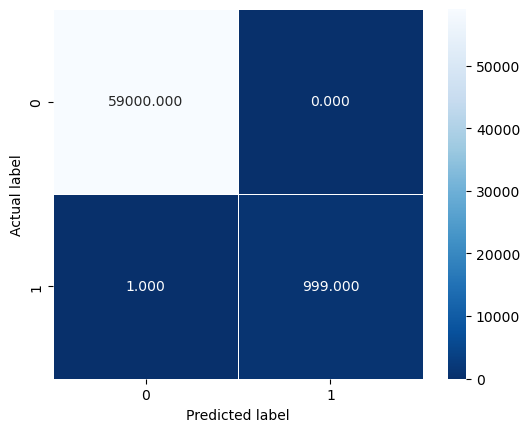

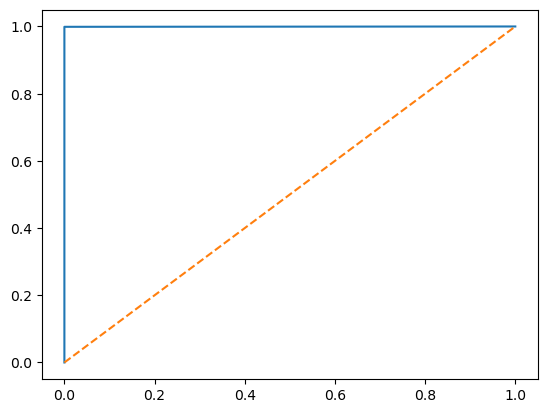

In [52]:
#Train Confusion Matrix
sns.heatmap(confusion_matrix(y_train,xgb_pred_train_smt), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"\nAccuracy for training set is {accuracy_score(y_train, xgb_pred_train_smt)}")
print(f"\nAUC for train is {roc_auc_score(y_train, xgb_pred_train_smt)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_train, xgb_pred_train_smt)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()


Accuracy for test set is 0.98225
AUC for test is 0.932352


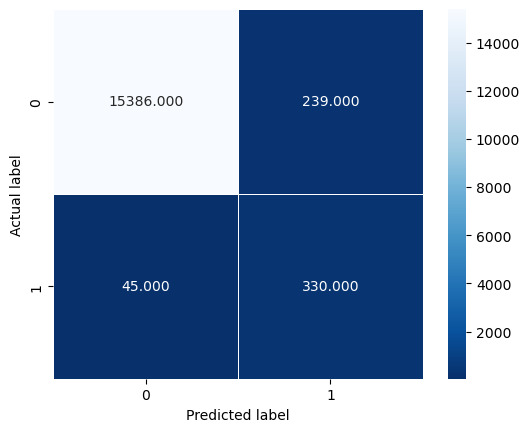

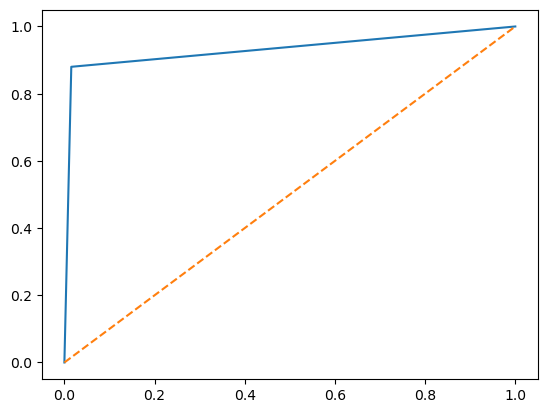

In [53]:
#Test Confusion Matrix 
sns.heatmap(confusion_matrix(y_test,xgb_pred_test_smt), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label')

print(f"\nAccuracy for test set is {accuracy_score(y_test, xgb_pred_test_smt)}")
print(f"AUC for test is {roc_auc_score(y_test, xgb_pred_test_smt)}")

fig, ax = plt.subplots()
fpr, tpr, thresh = roc_curve(y_test, xgb_pred_test_smt)
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], "--")
plt.show()

## 2. ISLR 6.6.3

### Answers 
a) steadily decrease
Till the point the s is sufficiently large the beta values that minimize RSS will become closer to the least square solution so it will steadily decrease upto that point  

b) decrease initially, and then eventually start increasing in a U shape

The model is initially a null model as s increases it will become more flexible and fit the data after which it will start overfitting 

c) steadily increase
This is because model flexibility will increase so an increase in variance will occur as well. After s is sufficiently large then the beta will be according to the least squares value and variance will not increase anymore 

d) steadily decrease
Increase in flexibilty will decrease bias

e) remain constant 
Irreducible error is noise and does not change regardless of the model 

## 3. ISLR 6.6.5

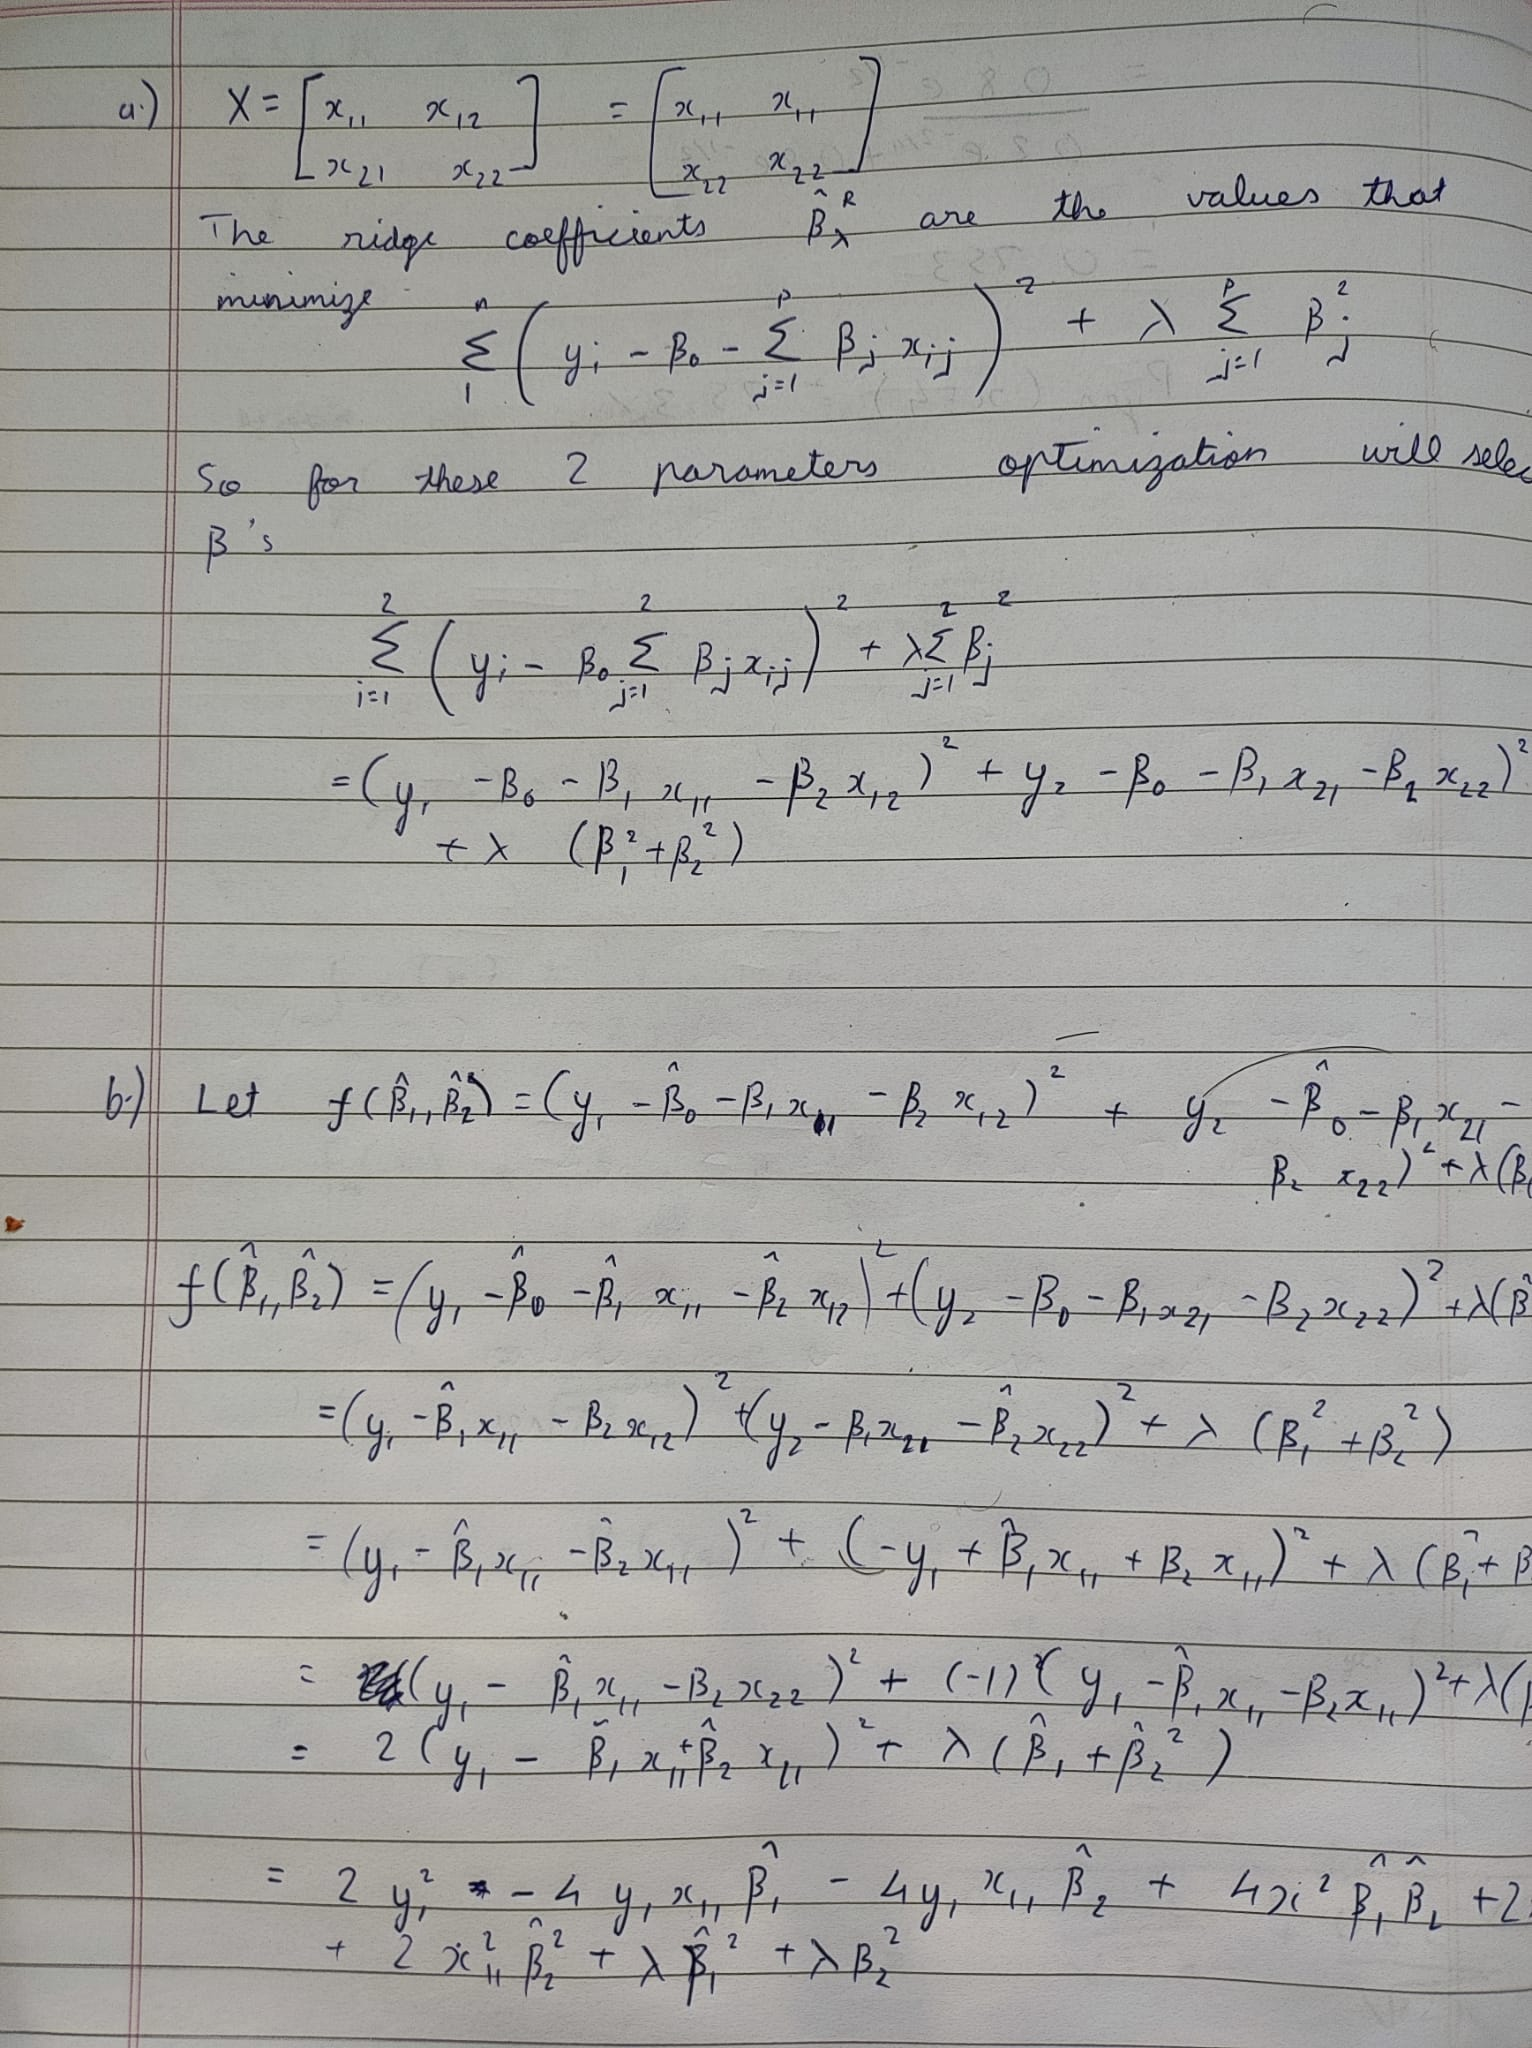

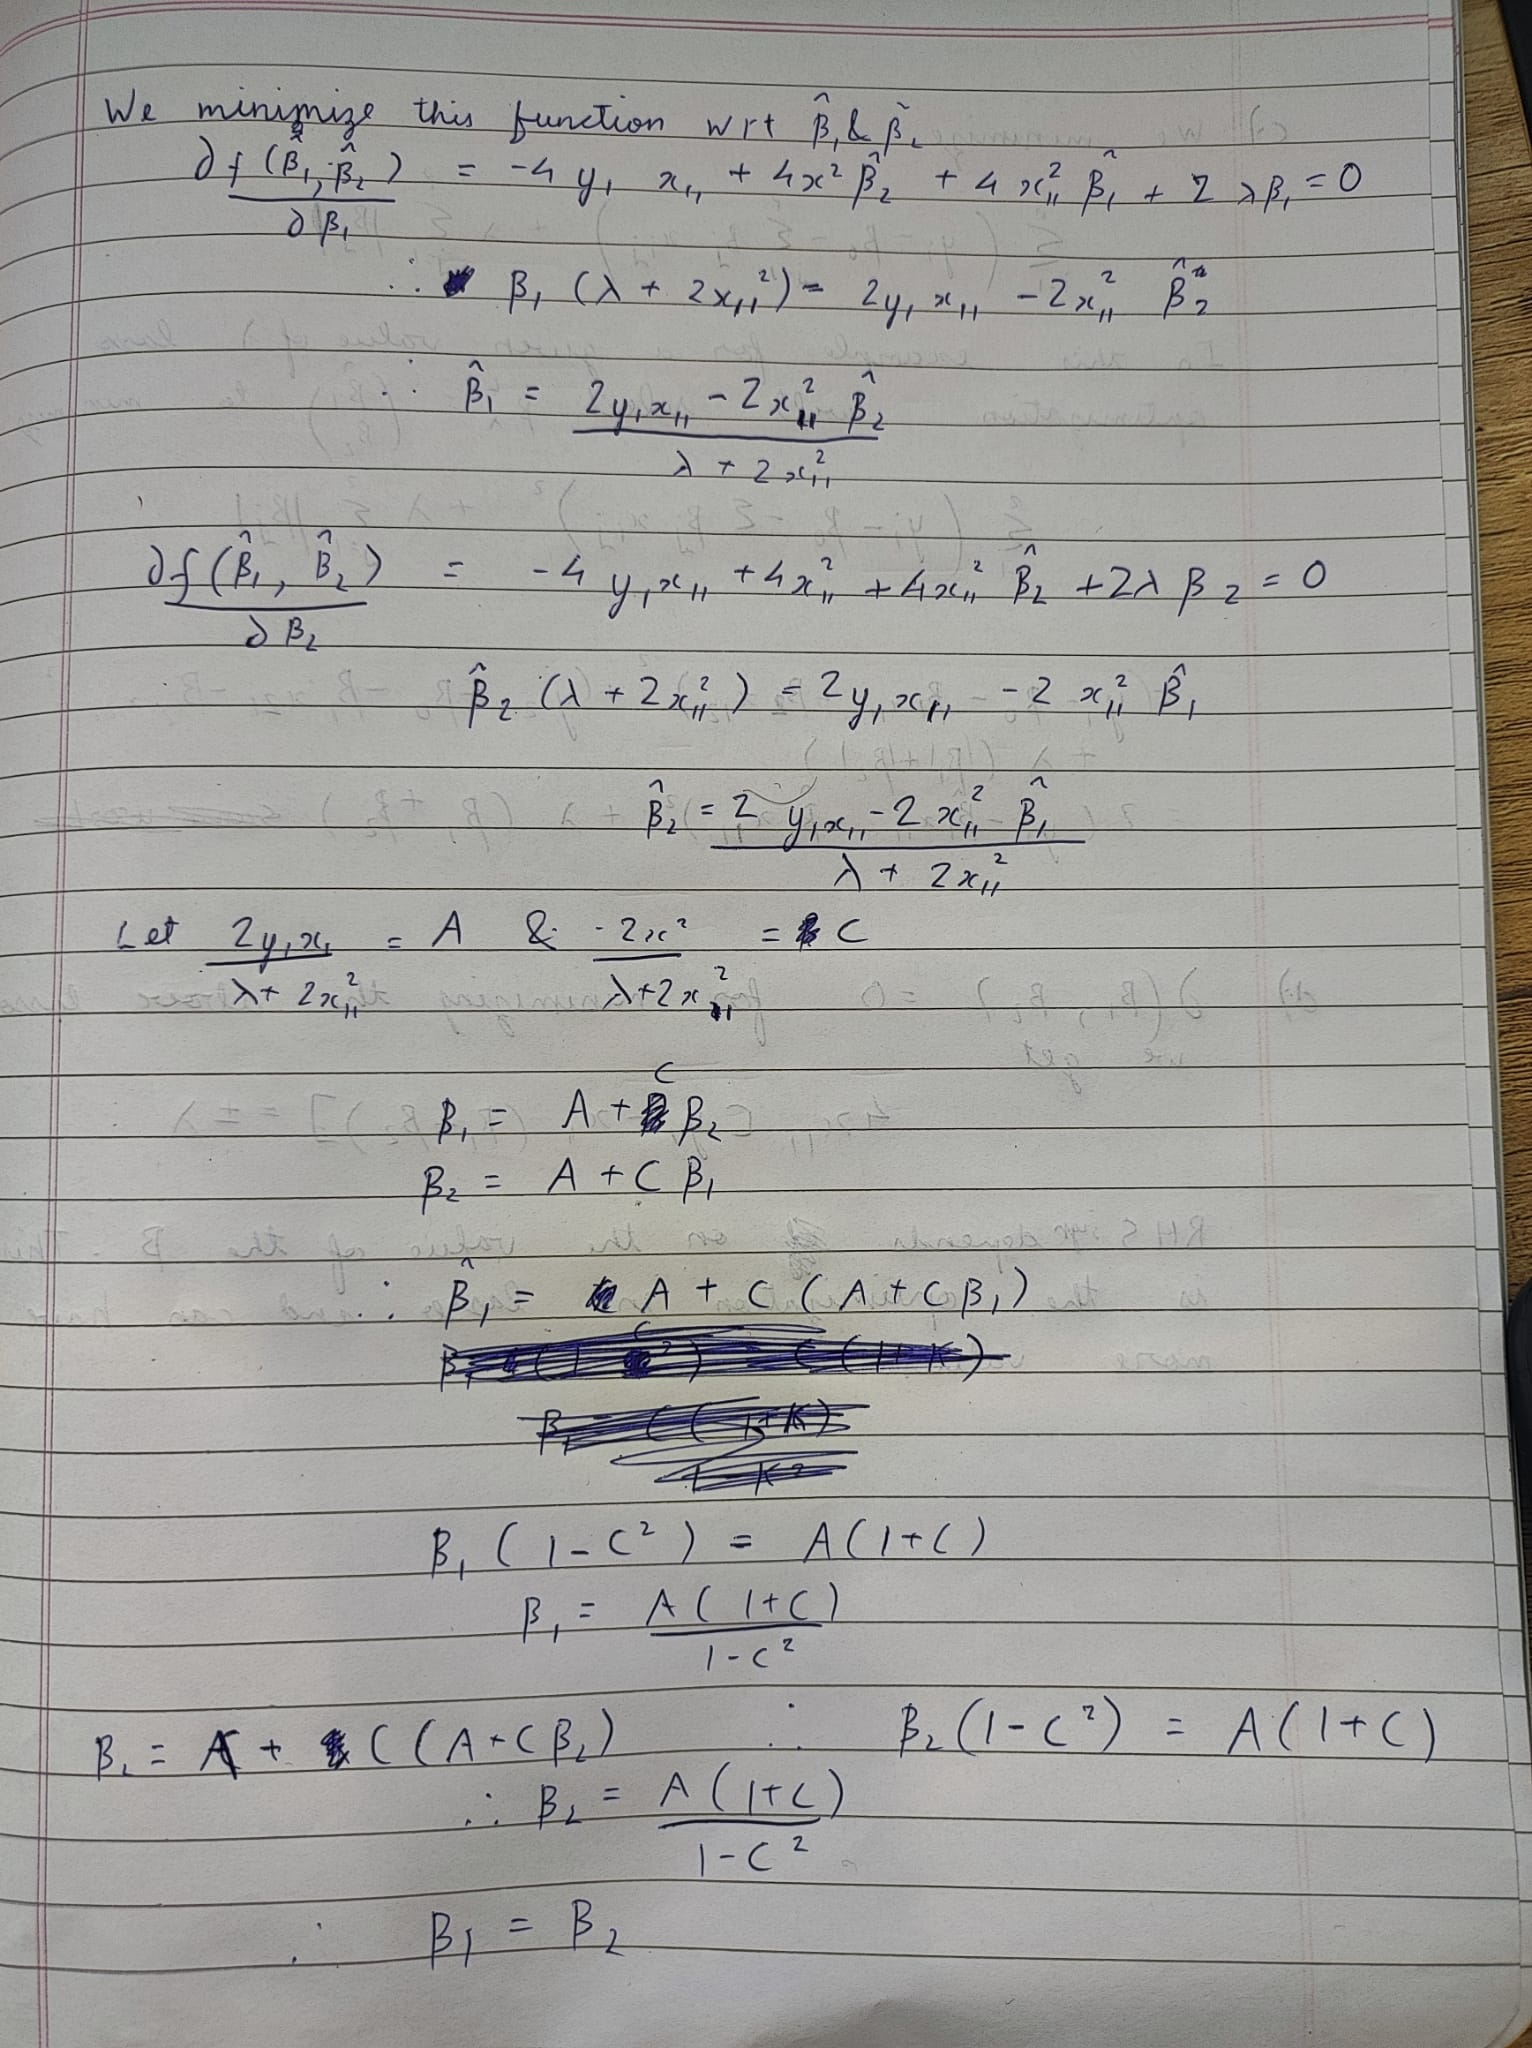

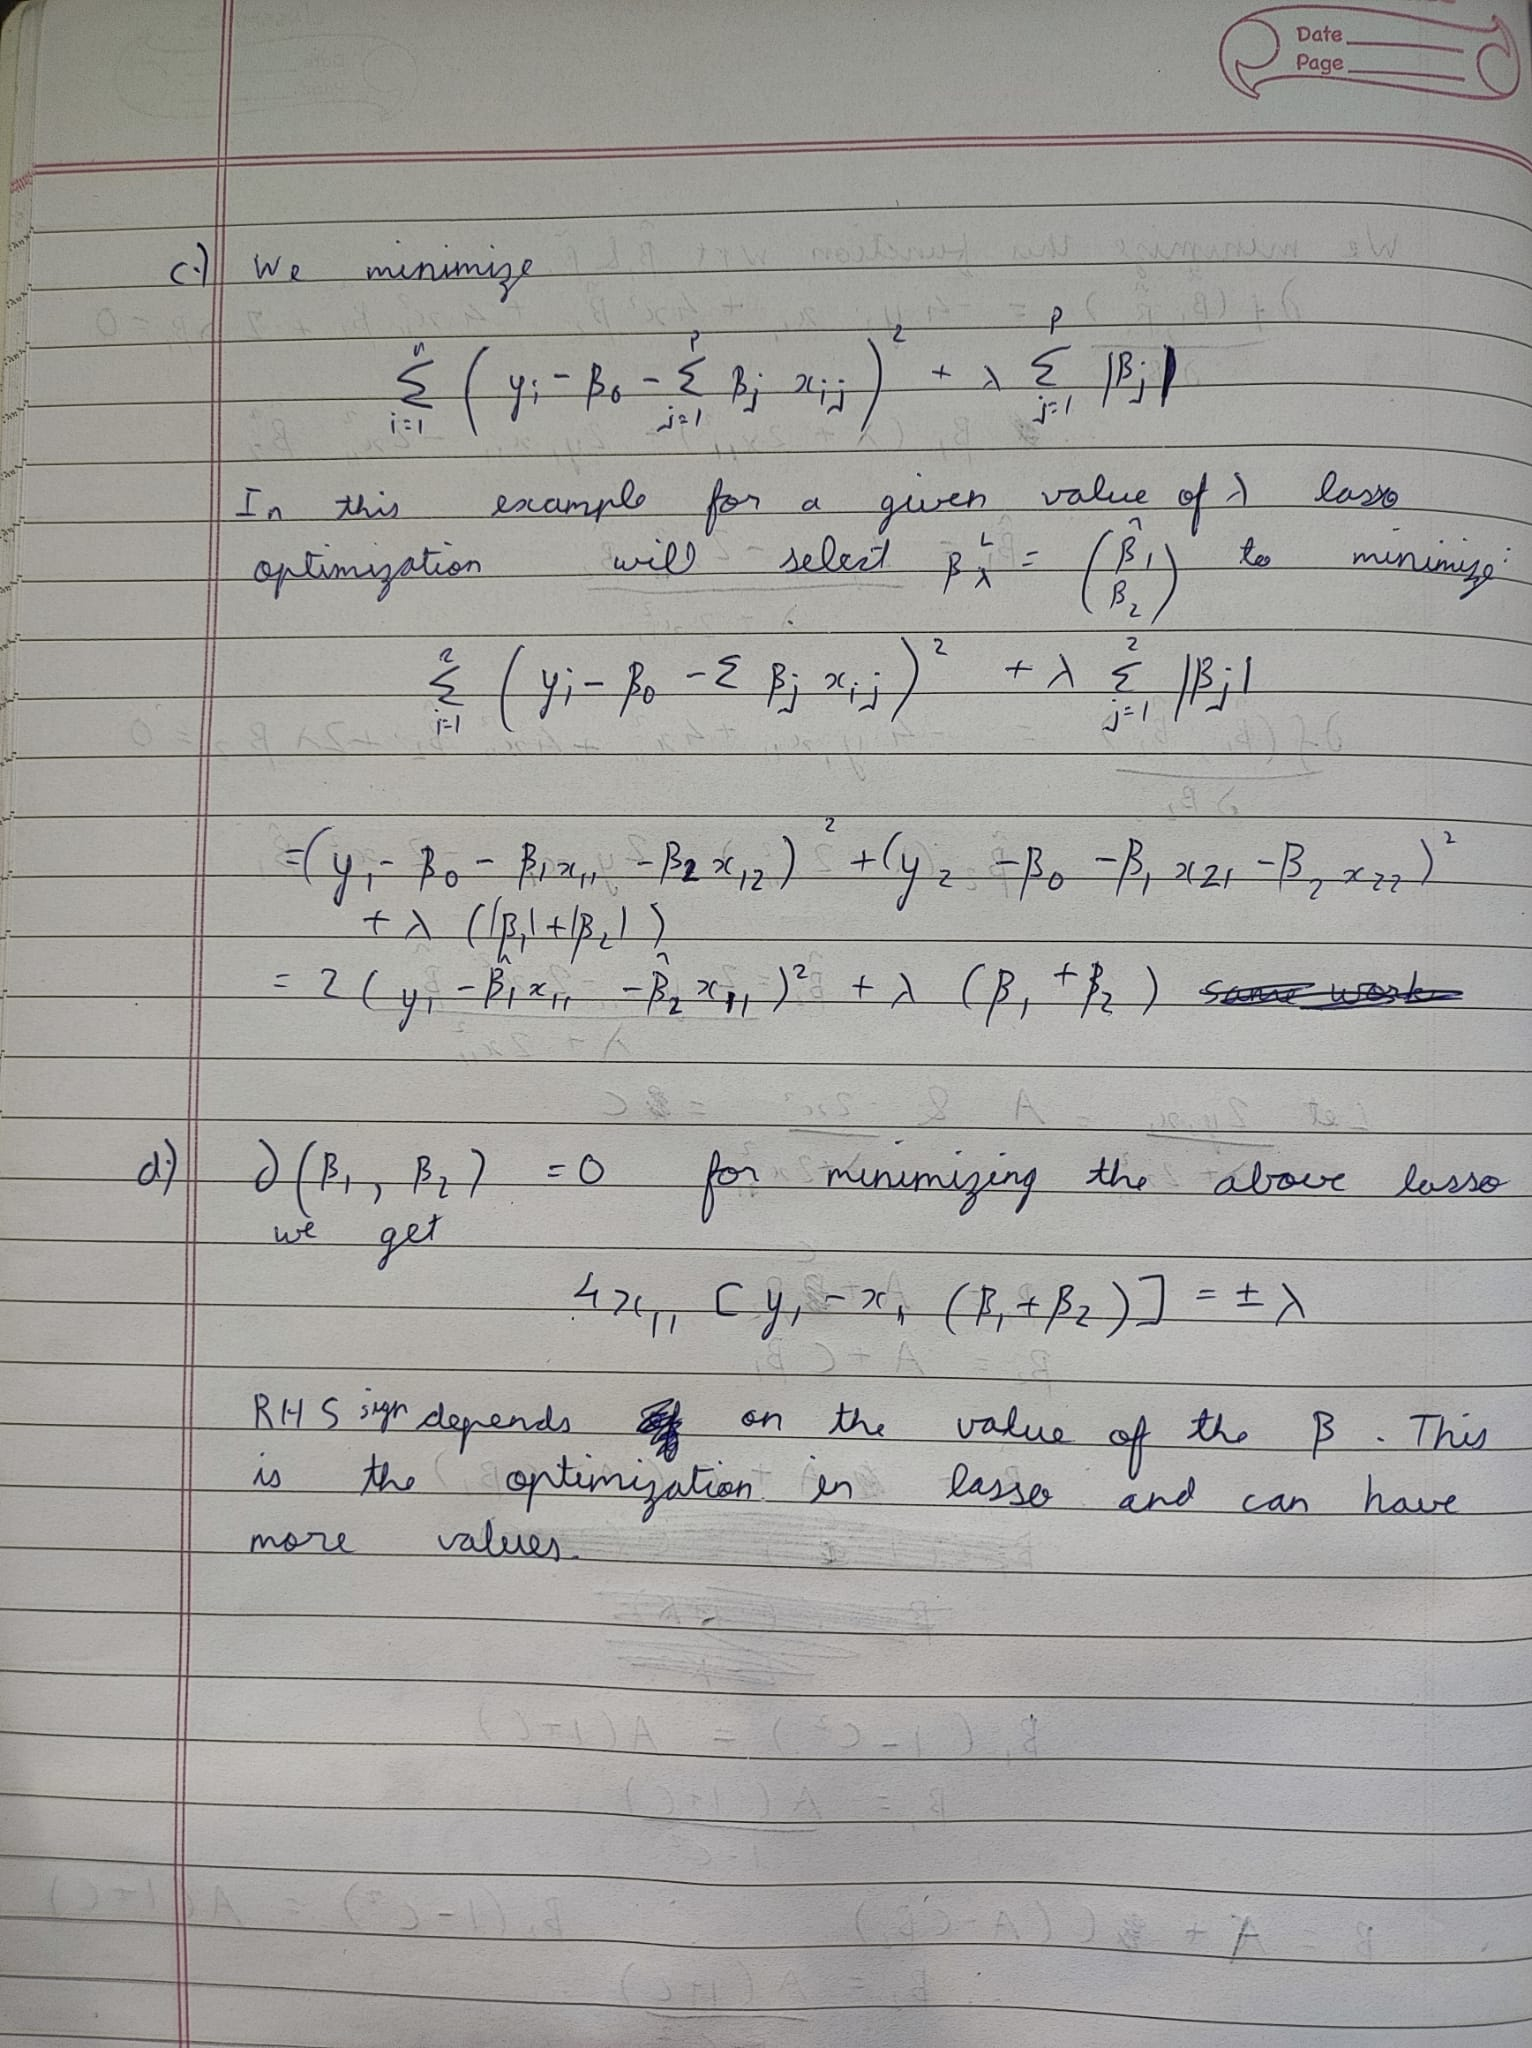

## 4. ISLR 8.4.5

### Majority Polling: 
In this, probabilities >= 0.5 are true. So False = 4, True= 6 and hence red samples > green samples and so the classification is red class.
### Average Probability:
Mean of probabilities = 0.45 
So get get the prediction as green class

## 5. ISLR 9.7.3

In [76]:
dct={'X1':[3,2,4,1,2,4,4],'X2':[4,2,4,4,1,3,1],'Y':['red','red','red','red','blue','blue','blue']}
df = pd.DataFrame(dct)
df

,X1,X2,Y
0,3,4,red
1,2,2,red
2,4,4,red
3,1,4,red
4,2,1,blue
5,4,3,blue
6,4,1,blue


<AxesSubplot: xlabel='X1', ylabel='X2'>

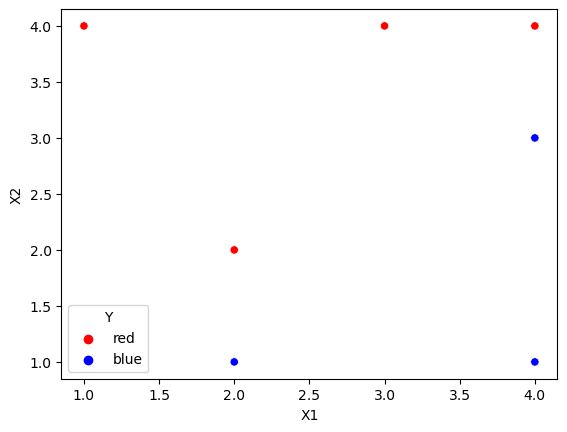

In [77]:
sns.scatterplot(df, x="X1", y="X2", hue="Y", palette=['red', 'blue'])

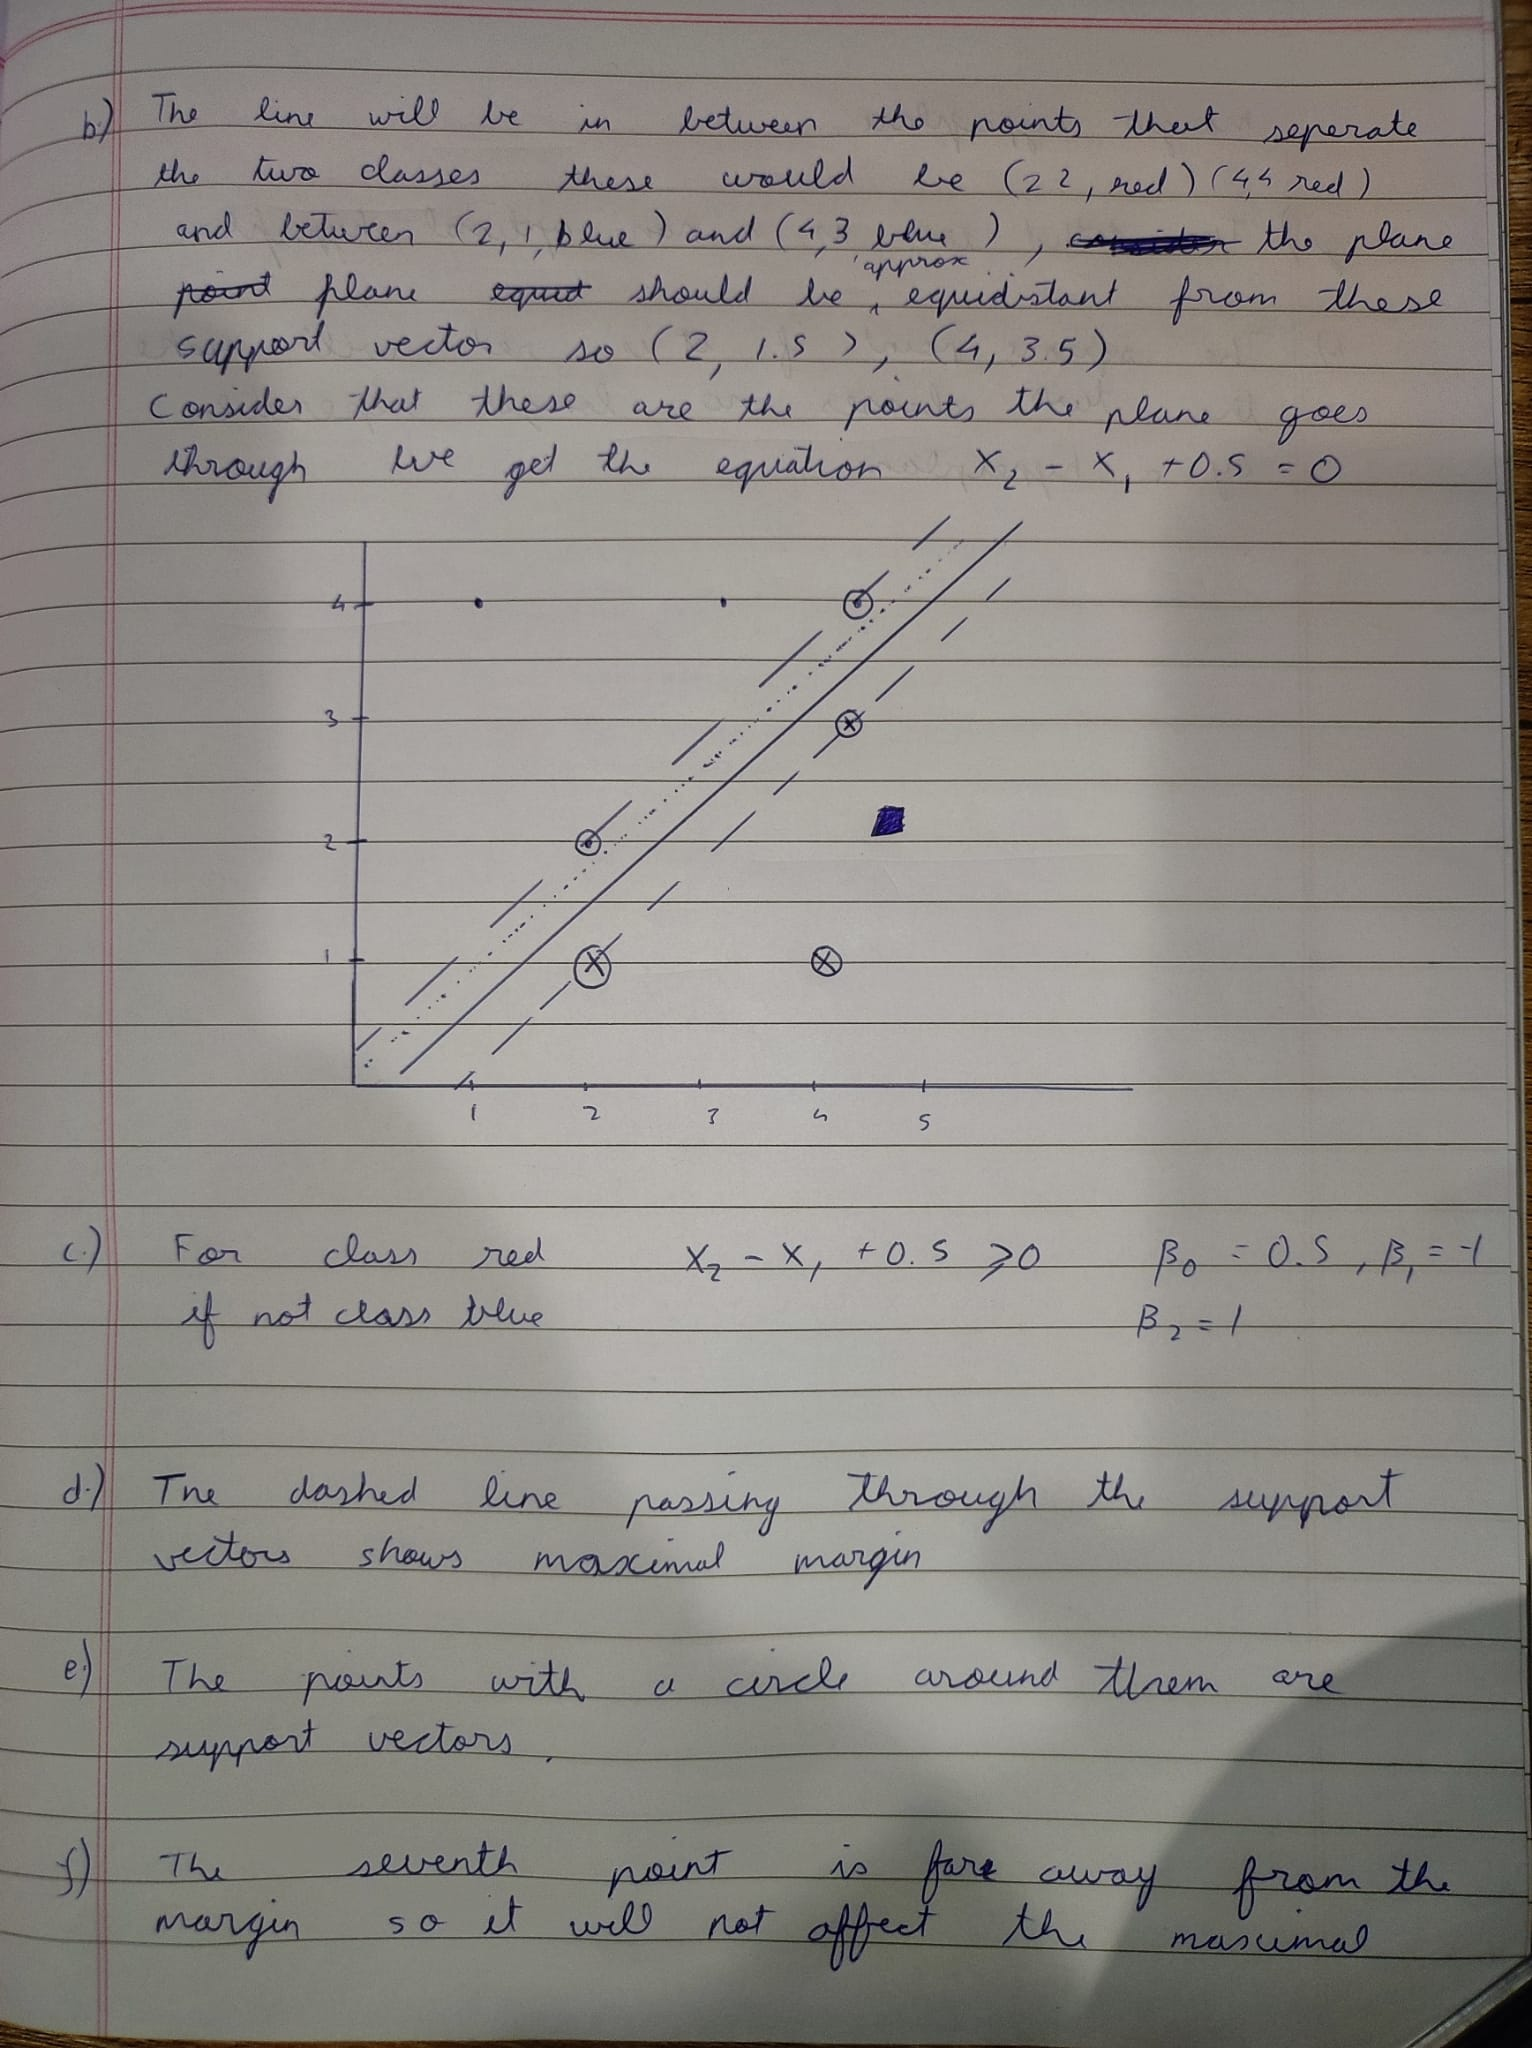

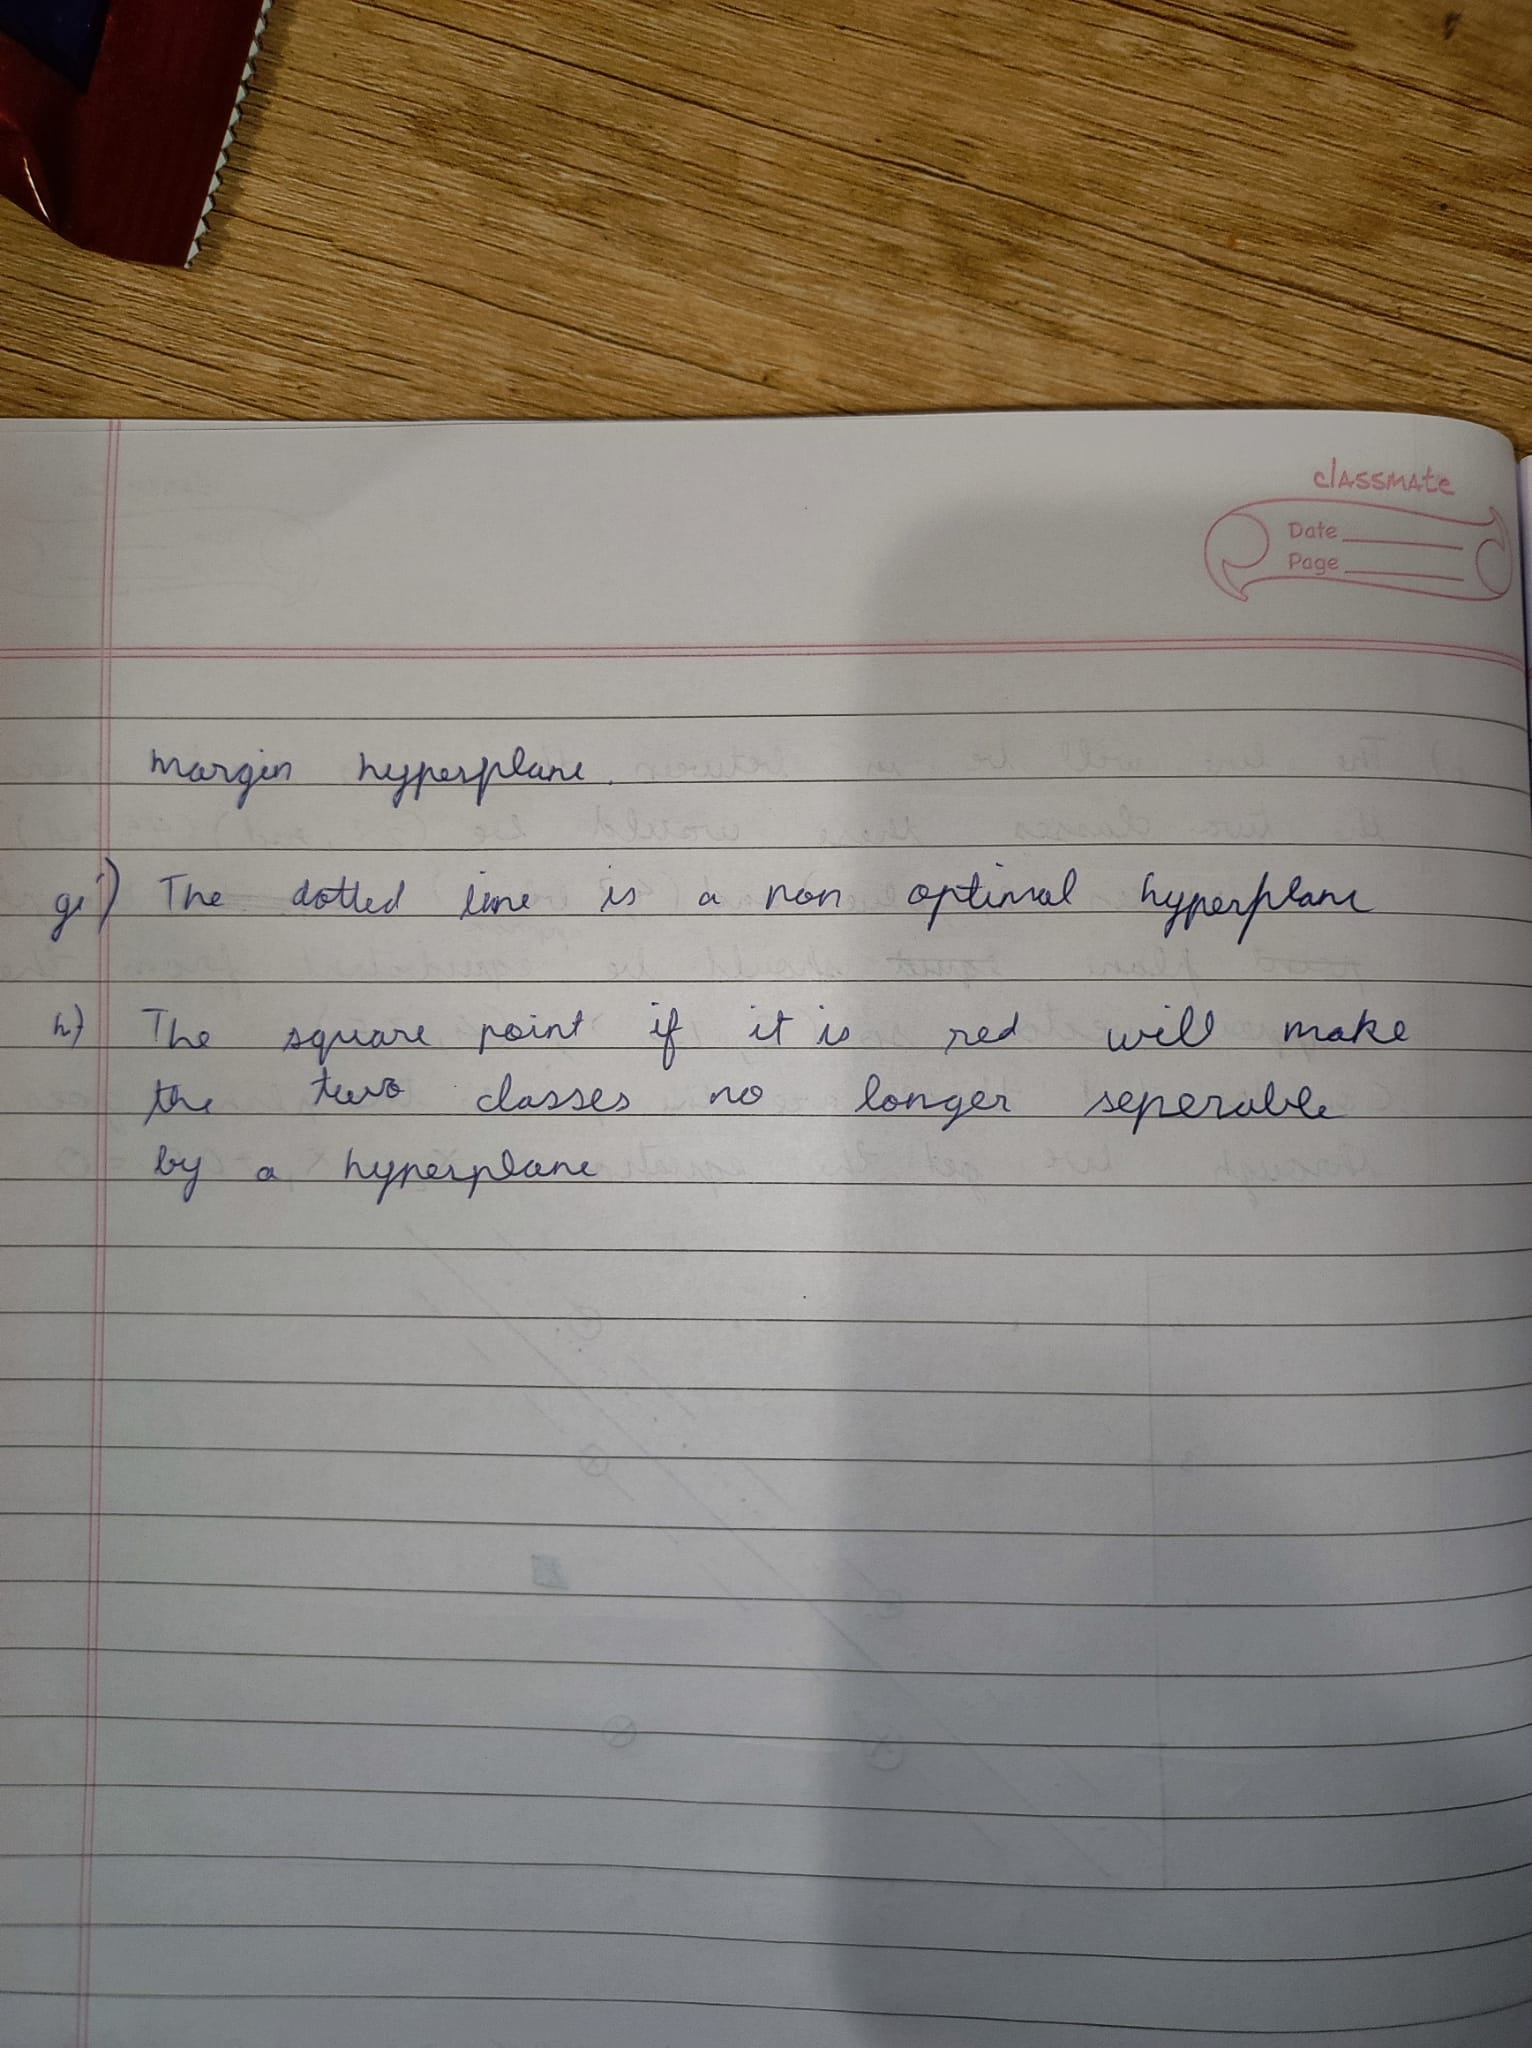